# Build a Deep Convolutional Generative Adversarial Network with PyTorch

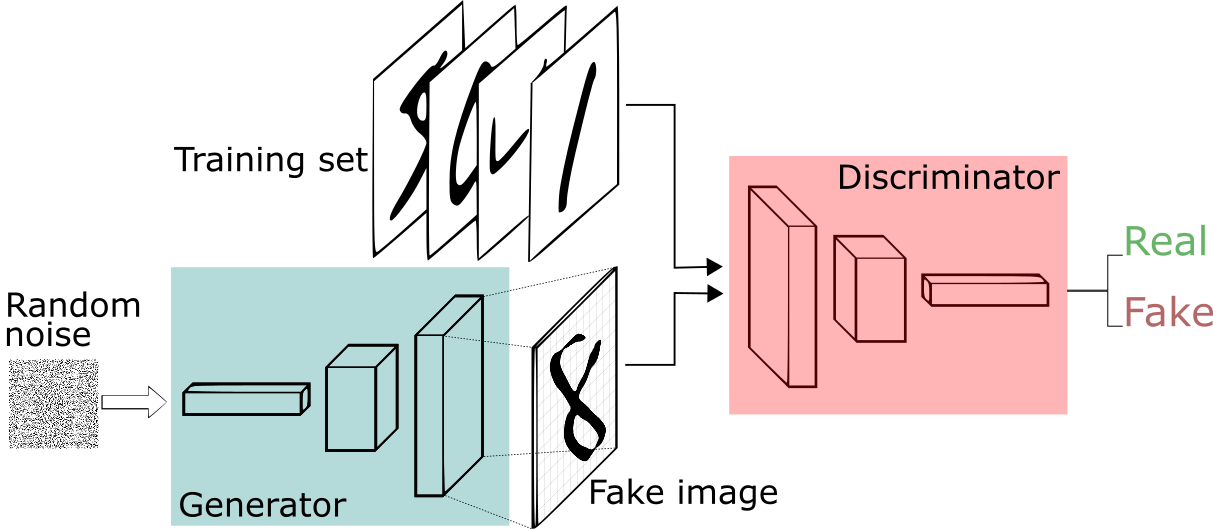

In [1]:
import torch 
torch.manual_seed(42)
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from tqdm.notebook import tqdm
import numpy as np

# Configurations

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # image = image.to(device)

batch_size = 128 # trainload, training loop

noise_dim = 64 # generator model

# Optimizers parameters
learning_rate = 0.0002
beta_1 = 0.5
beta_2 = 0.999

# Training variables
epochs = 20

# Load MNIST Dataset 

In [3]:
from torchvision import datasets, transforms as T

In [4]:
train_augs = T.Compose([
                        T.ToTensor(), # (height, width, channel) -> (channel, height, width)
                        T.Normalize((0.5,), (0.5,))
])

In [5]:
train_set = datasets.MNIST('MNIST/', download=True, train=True, transform=train_augs)

c:\users\dell\onedrive - institut national de statistique et d'economie appliquee\bureau\tweet_emotion_recognition\venv\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
train_set

Dataset MNIST
    Number of datapoints: 60000
    Root location: MNIST/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

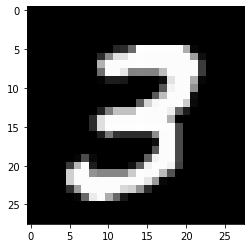

In [7]:
image, label = train_set[7]

plt.imshow(image.squeeze(), cmap='gray')

In [8]:
print(f'Total images of trainset is : {len(train_set)}')

Total images of trainset is : 60000


# Load Dataset Into Batches 

In [9]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [10]:
trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

In [11]:
print(f'Total of batches in trainloader : {len(trainloader)}')

Total of batches in trainloader : 469


In [12]:
data_iter = iter(trainloader)

images, _ = data_iter.next()

print(images.shape)

torch.Size([128, 1, 28, 28])


In [13]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, off_axes=False):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    if off_axes: plt.axis("off")
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


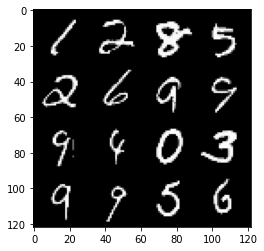

In [14]:
show_tensor_images(images)

# Create Discriminator Network 


In [15]:
from torch import nn
from torchsummary import summary

In [ ]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (4,4), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (3,3), stride = 2)                          #(bs, 32, 6, 6)
BatchNorm2d()                                                                                          #(bs, 32, 6, 6)
LeakyReLU()                                                                                            #(bs, 32, 6, 6)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (4,4), stride = 1)                          #(bs, 64, 3, 3)
BatchNorm2d()                                                                                          #(bs, 64, 3, 3)
LeakyReLU()                                                                                            #(bs, 64, 3, 3)
      |
      V
Conv2d( in_channels = 64, out_channels = 1, kernel_size = (3,3), stride = 2)                          #(bs, 1, 1, 1)

'''

In [20]:
def get_discriminator_block(in_channels, out_channels, kernel_size=3, stride=2, final_block=False):
  if final_block:
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride)
    )
  return nn.Sequential(
    nn.Conv2d(in_channels, out_channels, kernel_size, stride),
    nn.BatchNorm2d(out_channels),
    nn.LeakyReLU(0.2, inplace=True)
)

In [21]:
class Discriminator(nn.Module):

  def __init__(self):
    super(Discriminator, self).__init__()
    self.disc = nn.Sequential(
        get_discriminator_block(1, 16, kernel_size=4),
        get_discriminator_block(16, 32),
        get_discriminator_block(32, 64, kernel_size=4, stride=1),
        get_discriminator_block(64, 1, final_block=True),
    )

  def forward(self, img):
    disc_pred = self.disc(img)

    return disc_pred.view(len(disc_pred), -1)


In [22]:
D = Discriminator()
D.to(device)

summary(D, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             272
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 6, 6]           4,640
       BatchNorm2d-5             [-1, 32, 6, 6]              64
         LeakyReLU-6             [-1, 32, 6, 6]               0
            Conv2d-7             [-1, 64, 3, 3]          32,832
       BatchNorm2d-8             [-1, 64, 3, 3]             128
         LeakyReLU-9             [-1, 64, 3, 3]               0
           Conv2d-10              [-1, 1, 1, 1]             577
Total params: 38,545
Trainable params: 38,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.10
Params size (MB): 0.15
Estimated Tot

# Create Generator Network 

In [ ]:
'''

Network : Generator 

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1) 
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

In [23]:
def get_generator_block(in_channels, out_channels, kernel_size=3, stride=2, final_block=False):
  if final_block:
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
        nn.Tanh()
    )
    
  return nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True)
  )

In [24]:
class Generator(nn.Module):

  def __init__(self, z_dim=10):
    super(Generator, self).__init__()

    self.z_dim=z_dim
    self.gen = nn.Sequential(
        get_generator_block(z_dim, 256),
        get_generator_block(256, 128, kernel_size=4, stride=1),
        get_generator_block(128, 64),
        get_generator_block(64, 1, kernel_size=4, final_block=True),
    )
    

  def forward(self, r_noise_vec):

    # (bs, noise_dim) -> (bs, noise_dim, 1, 1)
    x=r_noise_vec.view(len(r_noise_vec), self.z_dim, 1, 1)
    return self.gen(x)

In [25]:
G = Generator(noise_dim)
G.to(device)

summary(G, input_size=(1,noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [26]:
# Replace Random initialized weights to Normal weights  

def weights_init(m):  
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [27]:
D=D.apply(weights_init)
G=G.apply(weights_init)

# Create Loss Function and Load Optimizer

In [28]:
# calculate real classification loss

def real_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.ones_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

# calculate fake classification loss

def fake_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.zeros_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

In [29]:
discriminator_opt = torch.optim.Adam(D.parameters(), lr=learning_rate, betas=(beta_1, beta_2)) # discriminator optimizer
generator_opt = torch.optim.Adam(G.parameters(), lr=learning_rate, betas=(beta_1, beta_2)) # generator optimizer

# Training Loop 

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step : 1000 | Discriminator loss : 0.27447420007735485 | Generator loss : 2.1089046721644715


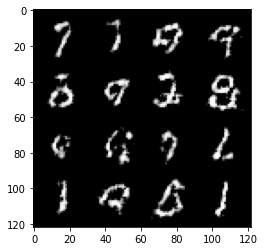

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


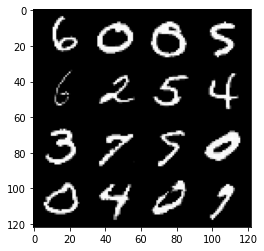

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step : 2000 | Discriminator loss : 0.3223552884906534 | Generator loss : 1.769561217896641


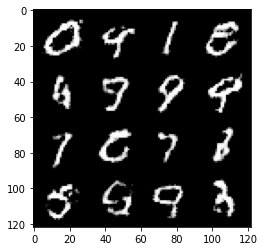

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


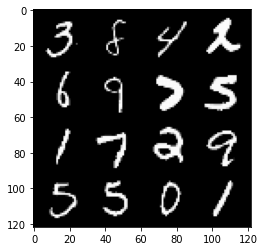

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step : 3000 | Discriminator loss : 0.3593802609443665 | Generator loss : 1.5521799822971238


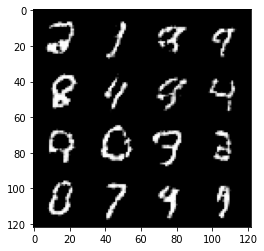

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


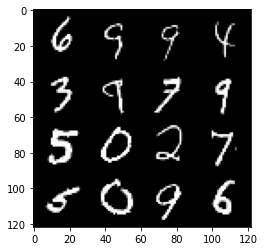

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step : 4000 | Discriminator loss : 0.38569684278965 | Generator loss : 1.5456134141534554


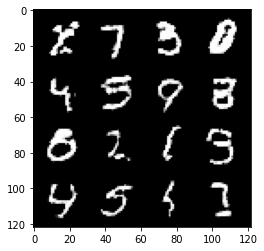

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


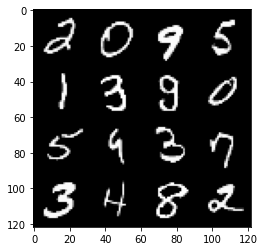

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step : 5000 | Discriminator loss : 0.41682121855020526 | Generator loss : 1.3858120651245123


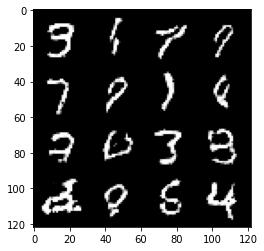

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


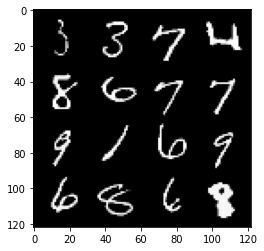

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step : 6000 | Discriminator loss : 0.4345211720466614 | Generator loss : 1.3279508326649685


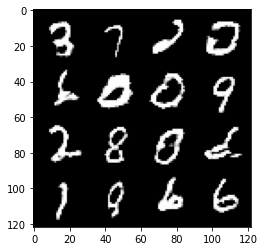

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


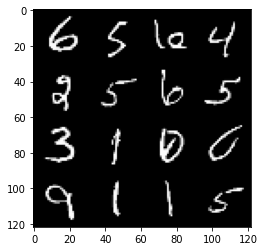

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step : 7000 | Discriminator loss : 0.4429564744830132 | Generator loss : 1.3117559305280426


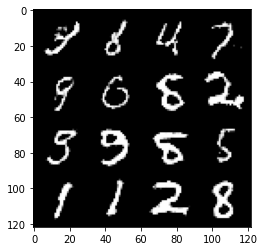

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


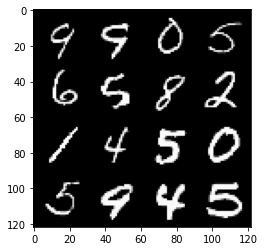

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step : 8000 | Discriminator loss : 0.4505543492436412 | Generator loss : 1.2967398607730887


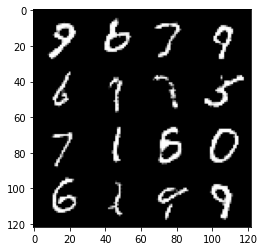

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


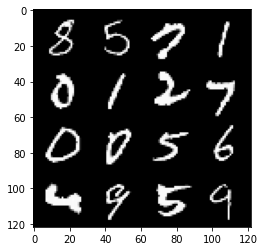

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step : 9000 | Discriminator loss : 0.4687371682226657 | Generator loss : 1.2726702545583268


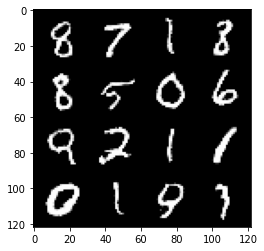

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


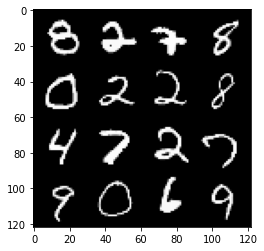

In [31]:
display_step=1000
current_step=0
total_discriminator_loss=0.0
total_generator_loss=0.0
fake_digits=[]
D_loss_list, G_loss_list = [], []


for i in range(epochs):
  for real_img, _ in tqdm(trainloader):
    
    batch_size=real_img.size(0)
    real_img = real_img.to(device)
    
    noise = torch.randn(batch_size, noise_dim, device=device)

    # find loss and update weights for discriminator

    discriminator_opt.zero_grad()

    fake_img = G(noise)
    discriminator_pred = D(fake_img.detach())
    discriminator_fake_loss = fake_loss(discriminator_pred)

    discriminator_pred = D(real_img)
    discriminator_real_loss = real_loss(discriminator_pred)

    discriminator_loss = (discriminator_fake_loss+discriminator_real_loss)/2

    total_discriminator_loss += discriminator_loss.item() / display_step

    discriminator_loss.backward(retain_graph=True)
    D_loss_list.append(discriminator_loss.item())
    discriminator_opt.step()

    # find loss and update weights for generator

    generator_opt.zero_grad()

    noise = torch.randn(batch_size, noise_dim, device=device)

    fake_img = G(noise)
    discriminator_pred = D(fake_img)
    generator_loss = real_loss(discriminator_pred)

    total_generator_loss += generator_loss.item() / display_step
    G_loss_list.append(generator_loss.item())

    generator_loss.backward()
    generator_opt.step()

    # Visualisation

    if current_step%display_step==0 and current_step > 0:
      print(f'Step : {current_step} | Discriminator loss : {total_discriminator_loss} | Generator loss : {total_generator_loss}')
      show_tensor_images(fake_img)
      show_tensor_images(real_img)
      total_generator_loss=0
      total_discriminator_loss=0

    if (current_step%display_step==0 and current_step > 0) or (i == epochs-1 and current_step == len(trainloader)-1):
      with torch.no_grad():
        fake=G(noise).detach().cpu()
      fake_digits.append(vutils.make_grid(fake[:64], padding=2, normalize=True, nrow=8))


    current_step+=1

# Model Evaluation

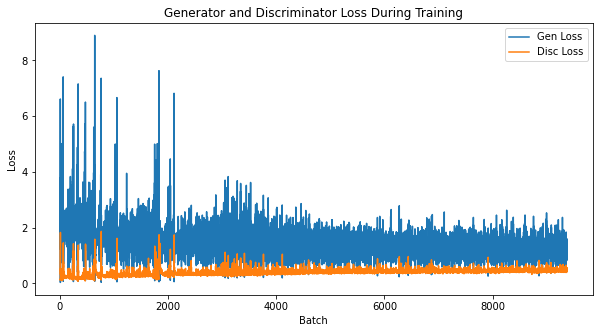

In [32]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_loss_list,label="Gen Loss")
plt.plot(D_loss_list,label="Disc Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.legend()
plt.show()

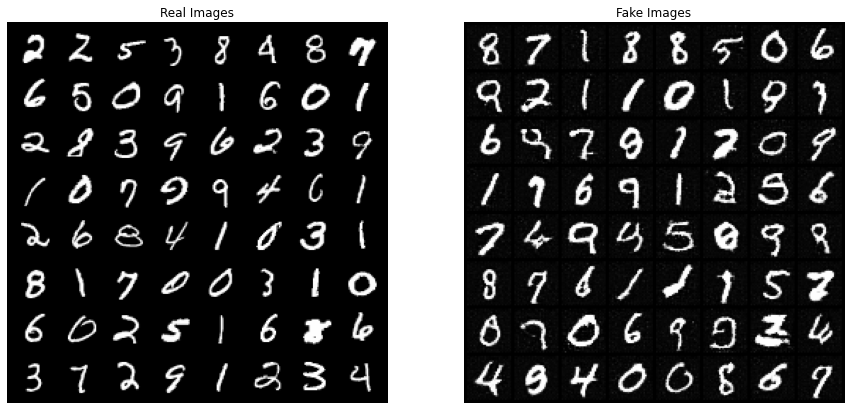

In [33]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(trainloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(fake_digits[-1],(1,2,0)))
plt.show()

In [34]:
def show_tensor_images_loop(tensor_img, itr, num_images = 16):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.title(f'Untrained model') if itr==0 else plt.title(f'After {itr} Batch')
    plt.axis("off")
    plt.show()

Generated handwritten digits images progression : 



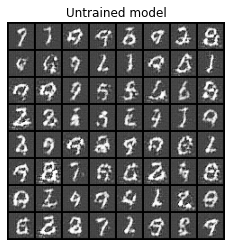

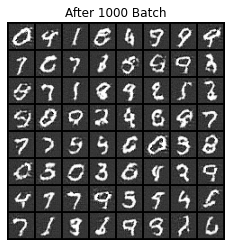

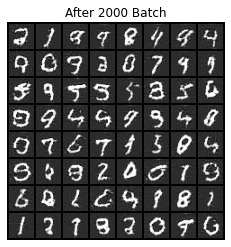

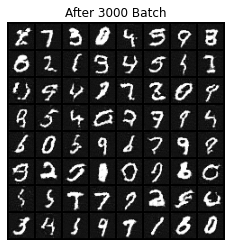

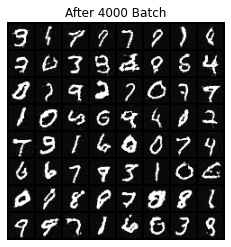

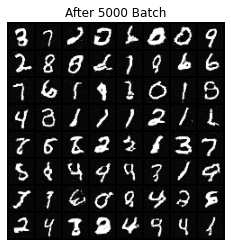

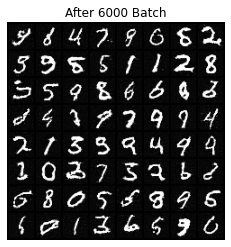

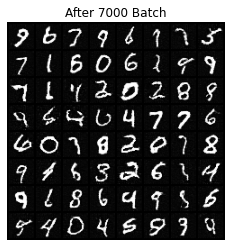

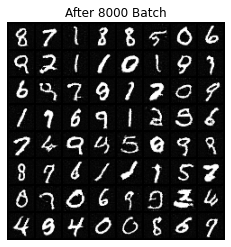

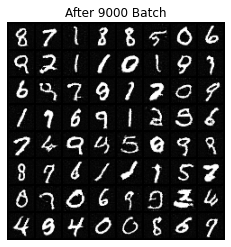

In [35]:
itr=0

print("Generated handwritten digits images progression : \n")

for i in range(len(fake_digits)):
    show_tensor_images_loop(fake_digits[i], itr)
    itr+=1000
    
show_tensor_images_loop(fake_digits[-1], len(fake_digits)*1000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Handwritten Digits Generated with Random Noise : 



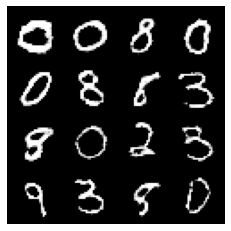

In [38]:
# Run after training is completed.
# Now we can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

print("Handwritten Digits Generated with Random Noise : \n")
show_tensor_images(generated_image, off_axes=True)